# Training the first neural net


## Contents
- Setting up a TensorFlow instance
- Downloading the Iris dataset which contains 4 physiological labels of 3 different kinds of Iris flowers: setosa, versicolor, and virginica
- Reshaping the data in order to feed them to a NN
- Creating a NN of a certain shape
- Train the NN on the training data using a loss function
- Test the NN on the test data

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

The cell above contains some "magic": it imports certain libraries that allow to use OS functionalities, plotting and most importantly the TensorFlow library.

Now we download the dataset. We could do this by hand, but since this is a standard data set, TensorFlow actually offers it on their website. Using keras and its utilities we can download and store the path to the downloaded file.

In [2]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname = os.path.basename(train_dataset_url), origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /Users/schlenga/.keras/datasets/iris_training.csv


The file is in .csv format, which you can open with Excel or Google Sheets. We take a quick peek here to get an idea what the file looks like.

In [3]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


We see in the first line the number of entries in the list; the number of measurements for each entry; the names of the three possible labels. The second and further lines show the 4 measurements and a label 0, 1, or 2 corresponding to the label names in the first row.

We whish to teach the machine to predict the label from the measurements.

In [4]:
def parse_csv(line):
    example_defaults = [[0.],[0.],[0.],[0.],[0]]
    parsed_line = tf.decode_csv(line, example_defaults)
    features = tf.reshape(parsed_line[:-1], shape=(4,))
    label = tf.reshape(parsed_line[-1], shape=())
    return features, label

In the cell above we bring the data into a format that we can use for tensorflow.

And now we are going to prepare the test dataset by shuffling it, putting it into batches and so on.

In [5]:
train_dataset = tf.data.TextLineDataset(train_dataset_fp)
train_dataset = train_dataset.skip(1)
train_dataset = train_dataset.map(parse_csv)
train_dataset = train_dataset.shuffle(buffer_size = 1000)
train_dataset = train_dataset.batch(32)

features, label = iter(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

example features: tf.Tensor([5.9 3.2 4.8 1.8], shape=(4,), dtype=float32)
example label: tf.Tensor(1, shape=(), dtype=int32)


Now comes the magic: we build the neural network. It consists of a layer of 10 neurons, another layer of 10 neurons and a last output layer with 3 nodes --> the 3 different labels.

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=(4,)),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(3)
])

Now we define the error, or loss, function and the gradient.

In [7]:
def loss(model, x, y):
    y_ = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.variables)

We set the training rate to 0.01.

In [8]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

Next up: the big show.

We loop through 200 epochs of comparing our predictions to the training samples and updating the weights according to the loss function. We print out loss and accuracy for every 50th epoch.

In [9]:
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()
    
    for x, y in train_dataset:
        grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.variables), global_step = tf.train.get_or_create_global_step())
        epoch_loss_avg(loss(model, x, y))
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)
        
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch, epoch_loss_avg.result(), epoch_accuracy.result()))
        

Epoch 000: Loss: 1.372, Accuracy: 30.000%
Epoch 050: Loss: 0.321, Accuracy: 93.333%
Epoch 100: Loss: 0.198, Accuracy: 97.500%
Epoch 150: Loss: 0.140, Accuracy: 98.333%
Epoch 200: Loss: 0.111, Accuracy: 97.500%


A little plot of loss and accuracy: We see that the loss ("error") decreases to about 10% and the accuracy up to somewhere between 95% and 99%.

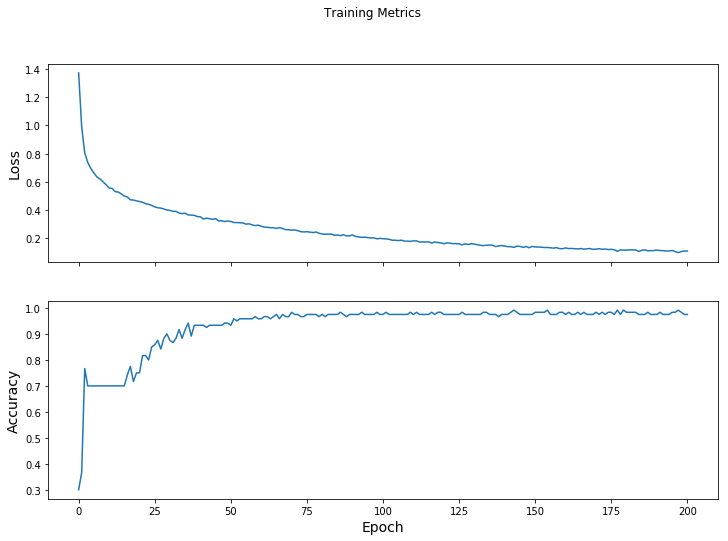

In [10]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12,8))
fig.suptitle("Training Metrics")

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy",fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

To test our model, we download some further sample data. They were not part of the test data, so they're unknown to our model. We check its predictions and find a pretty good accuracy.

In [11]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"
test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url), origin = test_url)

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)
test_dataset = test_dataset.map(parse_csv)
test_dataset = test_dataset.shuffle(1000)
test_dataset = test_dataset.batch(32)

In [12]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
    prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
    test_accuracy(prediction, y)
    
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%
